In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys; sys.path.append('..')
import numpy as np
from math import pi, sqrt
import pyzx as zx
%config InlineBackend.figure_format = 'svg'

In [16]:
import pyzx.phasepoly

qubits = 5
depth = 80
for i in range(100):
    if i%20 == 0:
        print(i, end='.')
    circ = zx.generate.cliffordT(qubits,depth,p_t=0.3)
    t = zx.tensor.tensorfy(circ)
    g = circ.copy()
    zx.simplify.clifford_simp(g,quiet=True)
    c = zx.extract.streaming_extract(g).to_basic_gates()
    c, blocks = pyzx.phasepoly.circuit_phase_polynomial_blocks(c, optimize=False)
    t2 = c.to_tensor()
    if not zx.tensor.compare_tensors(t,t2):
        raise Exception("Not equal")
    del t
    del t2

0.20.40.60.80.

Exception: Not equal

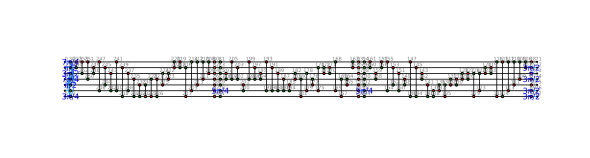

In [3]:
zx.draw(g,labels=True)

In [4]:
gg = g
g = gg.copy()

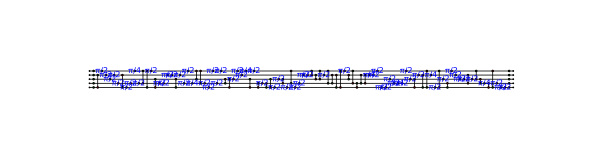

In [17]:
zx.draw(circ)

In [7]:
circ = zx.generate.cliffordT(15,1000000,0.1)
# g = circ.copy()
# zx.simplify.clifford_simp(g,quiet=False)
# g.normalise()
# #zx.draw(g,labels=True,figsize=(10,4))
# print(g)

In [3]:
%time zx.extract.circuit_extract(g, quiet=False)
print(g)

Cutting graph, 426 internal nodes to cut.
............10 % .............20 % ............30 % ..........40 % ..........50 % ............60 % .............70 % ........80 % ..............90 % ..........
Done, made 114 cuts
Extracting CNOT circuits, 115 iterations.
...................................................................................................................
Circuit extraction complete
id_simp
1710. 1286. 
finished in 3 iterations
Wall time: 5min 55s
Graph(27222 vertices, 278541 edges)


In [8]:
from pyzx.circuit import Circuit
%time c = Circuit.from_graph(circ)
print(c)

Wall time: 10.9 s
Circuit(15 qubits, 1000000 gates)


In [9]:
print(c)
c.gates[:100]

Circuit(12 qubits, 8005 gates)


[S(1),
 T*(5),
 CZ(1,5),
 CZ(3,5),
 S*(8),
 CZ(1,8),
 CZ(0,9),
 Z(11),
 HAD(7),
 S(7),
 CZ(5,7),
 HAD(4),
 T*(4),
 CZ(5,4),
 CZ(9,4),
 CZ(11,4),
 CZ(7,4),
 HAD(10),
 CZ(11,10),
 HAD(2),
 S(2),
 CZ(9,2),
 CZ(0,6),
 CZ(1,6),
 CZ(11,6),
 CNOT(1,0),
 CNOT(2,1),
 CNOT(3,1),
 CNOT(1,0),
 CNOT(4,2),
 CNOT(5,2),
 CNOT(2,0),
 CNOT(4,1),
 CNOT(4,3),
 CNOT(6,3),
 CNOT(7,6),
 CNOT(7,0),
 CNOT(7,1),
 CNOT(3,2),
 CNOT(6,4),
 CNOT(6,5),
 CNOT(6,0),
 CNOT(6,1),
 CNOT(6,2),
 CNOT(6,3),
 CNOT(6,4),
 CNOT(9,5),
 CNOT(9,7),
 CNOT(3,0),
 CNOT(3,1),
 CNOT(3,2),
 CNOT(11,4),
 CNOT(11,5),
 CNOT(11,6),
 CNOT(11,7),
 CNOT(11,8),
 CNOT(11,9),
 CNOT(9,11),
 CNOT(11,9),
 CNOT(8,11),
 CNOT(8,10),
 CNOT(7,8),
 CNOT(6,7),
 CNOT(8,11),
 CNOT(8,10),
 CNOT(7,9),
 CNOT(5,9),
 CNOT(4,9),
 CNOT(4,6),
 CNOT(6,4),
 CNOT(4,11),
 CNOT(6,10),
 CNOT(5,8),
 CNOT(5,7),
 CNOT(2,3),
 CNOT(2,11),
 CNOT(4,10),
 CNOT(4,9),
 CNOT(4,8),
 CNOT(4,7),
 CNOT(2,6),
 CNOT(4,5),
 CNOT(2,11),
 CNOT(0,10),
 CNOT(2,9),
 CNOT(2,8),
 CNOT(2,7),
 CNO

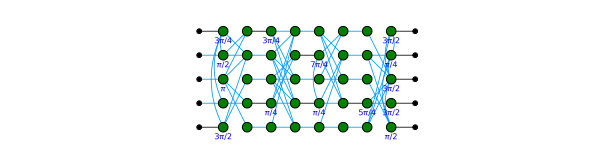

In [19]:
zx.extract.greedy_cut_extract(g)
zx.draw(g)

In [20]:
t = zx.tensor.tensorfy(circ)
t2 = zx.tensor.tensorfy(g)
zx.tensor.compare_tensors(t,t2)

True

In [21]:
l = list(reversed(range(1,g.depth()-1,2)))
l

[7, 5, 3, 1]

In [34]:
zx.extract.clifford_extract(g,1,2)
t2 = zx.tensor.tensorfy(g)
zx.tensor.compare_tensors(t,t2)

False

In [42]:
t2 *= 10**6

In [44]:
zx.tensor.compare_tensors(t,t2)

True

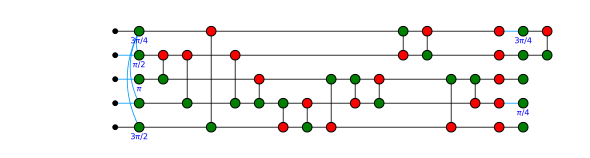

In [32]:
zx.draw(g,rows=(0,18))

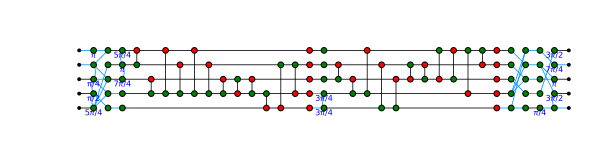

In [51]:
zx.draw(g)

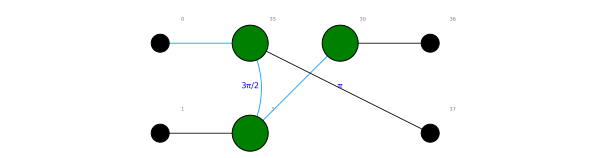

In [25]:
g = circ.copy()
zx.simplify.clifford_simp(g,quiet=True)
zx.extract.normalise(g)
t = zx.tensor.tensorfy(g)
#zx.extract.clifford_extract(g,1,2)
#t2 = zx.tensor.tensorfy(g)
zx.draw(g,labels=True)

In [26]:
t

array([[[[ 0.70710678+0.j        , -0.        -0.70710678j],
         [ 0.        +0.j        ,  0.        +0.j        ]],

        [[ 0.        +0.j        ,  0.        +0.j        ],
         [ 0.        +0.j        ,  0.        +0.j        ]]],


       [[[ 0.        +0.j        ,  0.        +0.j        ],
         [ 0.        +0.j        ,  0.        +0.j        ]],

        [[ 0.70710678+0.j        , -0.        -0.70710678j],
         [ 0.        +0.j        ,  0.        +0.j        ]]]])

In [21]:
t2

array([[[[[[[[ 0.     -0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     ,  0.     +0.j     ]],

            [[ 0.     +0.03125j, -0.03125+0.j     ],
             [-0.03125+0.j     ,  0.     +0.03125j]]],


           [[[-0.03125+0.j     ,  0.     +0.03125j],
             [-0.     -0.03125j,  0.03125-0.j     ]],

            [[ 0.     -0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     , -0.     +0.j     ]]]],



          [[[[ 0.     +0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     ,  0.     +0.j     ]],

            [[ 0.     +0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     ,  0.     +0.j     ]]],


           [[[ 0.     +0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     ,  0.     +0.j     ]],

            [[ 0.     +0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     ,  0.     +0.j     ]]]]],




         [[[[[ 0.     +0.j     ,  0.     +0.j     ],
             [ 0.     +0.j     ,  0.     +0.j     ]],

            [[

In [ ]:
t = tensorfy(circ)
t

In [ ]:
t = tensorfy(circ)
g = circ.copy()

zx.simplify.clifford_simp(g)
#g.set_phase(3,0)
t2 = tensorfy(g)
zx.draw(g,labels=True)
#np.allclose(t,t2)
#print(t,"\n\n", t2)

In [ ]:
compare_tensors(t,t2)

In [ ]:
t2

In [ ]:
zx.draw(g.adjoint(),labels=True)
tadj = tensorfy(g.adjoint())
tadj
#np.tensordot(t2,tadj,axes=([2,3],[0,1]))
#id2 = Z_to_tensor(2,0)
#np.transpose(np.tensordot(id2,id2,axes=0),[0,2,1,3])

In [ ]:
#tensor[1,1,0,1]
np.transpose(tensor, [3,2,0,1])
#np.transpose(tensor, [0,3,2,1])

In [ ]:
id2 = Z_to_tensor(2,0)
z = Z_to_tensor(3,0)
print(z)
x = X_to_tensor(3,0)
print(x)
x2 = X_to_tensor(4,0)
a = np.tensordot(id2,z,axes=0)
cnot = np.tensordot(a,x,axes=([1,4],[2,0]))
cnot
#np.transpose(cnot,[0,1,3,2])
np.transpose(np.tensordot(z,x,(0,0)),[0,2,1,3])

In [ ]:
i = 10
b = [int(j) for j in bin(i)[2:]]
b

In [ ]:
l = [1,2,3]
l.count(2)

In [ ]:
id2 = [[1,0],[0,1]]
a = [[[1,0],[0,0]],[[0,0],[0,1]]]
b = [[[1,0],[0,1]],[[0,1],[1,0]]]
print(np.einsum("klm,iln->kimn",a,b))
#print(np.tensordot(a,b, axes=(0,0)))
c = np.tensordot(id2, a, axes=0)
cnot = np.tensordot(c,b,axes=([1,3],[1,0]))
#print(cnot)
cnot2 = np.tensordot(id2,np.tensordot(a,b,axes=(1,0)),axes=(1,0))
#print(cnot2)
np.einsum("ij,klm,jln->ikmn",id2,a,b)

In [12]:
import numpy as np
np.set_printoptions(suppress=True)
id2 = np.identity(2)
t1 = np.tensordot(id2,id2,axes=0)
s = np.array([[1,0],[0,-1]])
t2 = np.tensordot(s,s,axes=0)
t3 = np.tensordot(t1,t2,axes=([1,3],[0,2]))
t3 = np.einsum("abcd,bedf",t1,t2)
np.transpose(t3,[0,2,1,3])

array([[[[ 1.,  0.],
         [ 0., -1.]],

        [[ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.]],

        [[-1.,  0.],
         [ 0.,  1.]]]])

In [15]:
t2 = np.tensordot(t1,s,axes=(1,0))
t3 = np.tensordot(t2,s,axes=(2,0))
np.transpose(t3,[0,2,1,3])

array([[[[ 1.,  0.],
         [ 0., -1.]],

        [[ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.]],

        [[-1.,  0.],
         [ 0.,  1.]]]])

In [7]:
from pyzx.tensor import *
import numpy as np
import random
random.seed(500)
g = zx.generate.cliffords(3,15)
t = tensorfy(g)
adj = g.adjoint()
t2 = tensorfy(adj)
#t3 = np.transpose(t2.conjugate(),[1,0,3,2,5,4])
#np.transpose(np.tensordot(t,t2,axes=([1,3,5],[0,2,4])),[0,3,1,4,2,5])
comp1 = compose_tensors(t,t2)
g.compose(adj)
comp2 = tensorfy(g)
comp1

array([[[[[[ 0.015625-0.j, -0.      +0.j],
           [-0.      +0.j,  0.015625-0.j]],

          [[ 0.      +0.j, -0.      +0.j],
           [-0.      -0.j,  0.      +0.j]]],


         [[[ 0.      +0.j,  0.      +0.j],
           [ 0.      +0.j,  0.      +0.j]],

          [[ 0.015625-0.j,  0.      +0.j],
           [-0.      +0.j,  0.015625-0.j]]]],



        [[[[ 0.      -0.j,  0.      -0.j],
           [ 0.      +0.j, -0.      -0.j]],

          [[ 0.      -0.j, -0.      -0.j],
           [-0.      -0.j, -0.      -0.j]]],


         [[[-0.      +0.j,  0.      -0.j],
           [ 0.      +0.j,  0.      -0.j]],

          [[-0.      -0.j, -0.      +0.j],
           [-0.      -0.j, -0.      -0.j]]]]],




       [[[[[ 0.      +0.j, -0.      +0.j],
           [ 0.      -0.j, -0.      +0.j]],

          [[-0.      -0.j, -0.      -0.j],
           [-0.      -0.j,  0.      -0.j]]],


         [[[ 0.      +0.j,  0.      -0.j],
           [ 0.      -0.j, -0.      +0.j]],

          [[-0. 

In [9]:
from pyzx.circuit import Circuit
Circuit.add_gate.__name__

'add_gate'